In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv('../Dữ liệu Lịch sử DXG.csv')
df['Ngày']=pd.to_datetime(df.Ngày, format ="%d/%m/%Y")
  # Sort the dataframe by date in ascending order
df = df.sort_values('Ngày')

In [33]:
# Rename columns
df.rename(columns={"Ngày":"Date","Lần cuối":"Close","Mở":"Open","Cao":"High","Thấp":"Low","KL": "Volume","% Thay đổi": "percent_change"}, inplace= True)


In [34]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
  df['Close'] = df['Close'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Volume'] = df['Volume'].apply(convert_to_number)
  df['percent_change'] = df['percent_change'].apply(lambda x: float(x.strip('%'))/100)

In [35]:
df

,Date,Close,Open,High,Low,Volume,percent_change
1348,2017-12-01,12251.8,11949.3,12403.1,11919.0,8.61M,2.79%
1347,2017-12-04,12705.6,12463.6,12705.6,12282.1,9.42M,3.70%
1346,2017-12-05,12282.1,12705.6,12917.3,12282.1,11.06M,-3.33%
1345,2017-12-06,12161.1,12161.1,12342.6,11919.0,7.72M,-0.99%
1344,2017-12-07,12100.6,12161.1,12312.3,11858.5,5.23M,-0.50%
...,...,...,...,...,...,...,...
4,2023-04-24,12750.0,12500.0,12850.0,12500.0,7.78M,0.79%
3,2023-04-25,12550.0,12950.0,12950.0,12550.0,10.09M,-1.57%
2,2023-04-26,12600.0,12600.0,12700.0,12400.0,7.82M,0.40%
1,2023-04-27,13200.0,12700.0,13450.0,12600.0,30.21M,4.76%


In [36]:
tranformData(df)

In [37]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [38]:
df

,Close,Open,High,Low,Volume,percent_change
Date,,,,,,
2017-12-01,12251.8,11949.3,12403.1,11919.0,8610000.0,0.0279
2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370
2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
...,...,...,...,...,...,...
2023-04-24,12750.0,12500.0,12850.0,12500.0,7780000.0,0.0079
2023-04-25,12550.0,12950.0,12950.0,12550.0,10090000.0,-0.0157
2023-04-26,12600.0,12600.0,12700.0,12400.0,7820000.0,0.0040


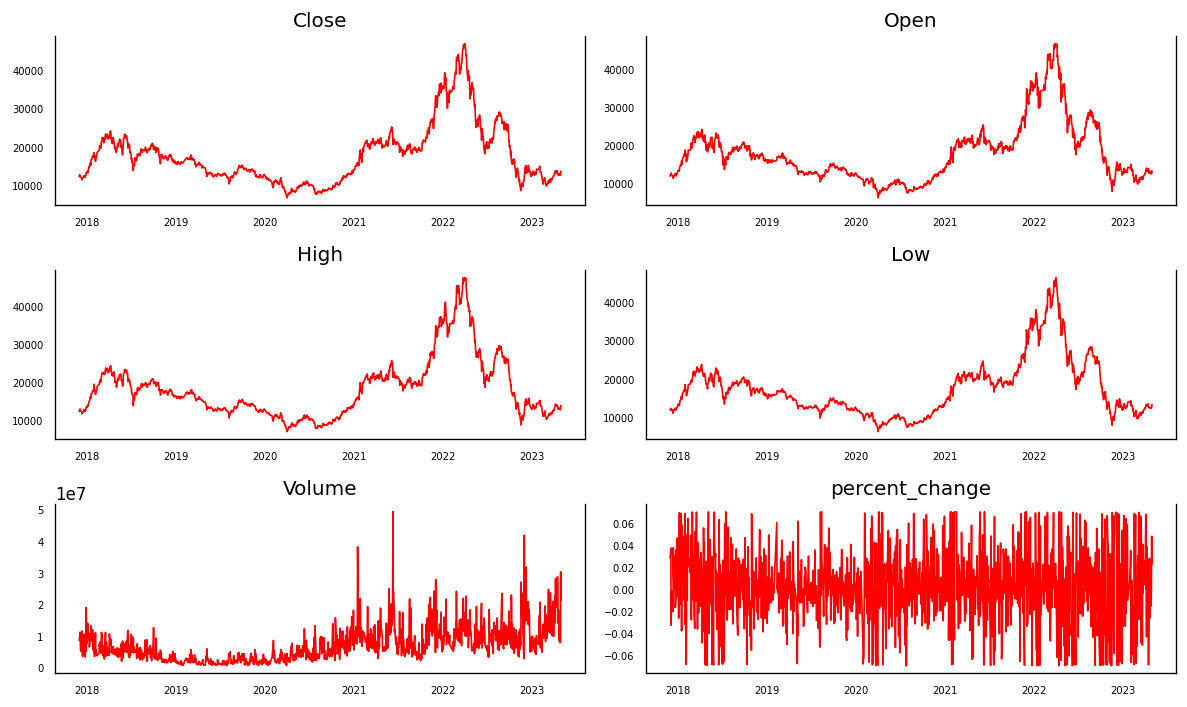

In [39]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [40]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Close_x,Open_x,High_x,Low_x,Volume_x,percent_change_x
Close_y,1.0000,0.0002,0.0302,0.0141,0.1147,0.0014
Open_y,0.0000,1.0000,0.0000,0.0000,0.0140,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Volume_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0377
percent_change_y,0.0812,0.0324,0.1144,0.0639,0.0752,1.0000


In [41]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Close  ::  712.56    > 83.9383   =>   True
Open   ::  463.72    > 60.0627   =>   True
High   ::  246.75    > 40.1749   =>   True
Low    ::  95.99     > 24.2761   =>   True
Volume ::  32.03     > 12.3212   =>   True
percent_change ::  0.46      > 4.1296    =>   False


In [42]:
nobs=int(0.2*len(df))
n_train = int(0.6 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(809, 6)
(269, 6)
(271, 6)


In [43]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [44]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6032
 No. Lags Chosen       = 16
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.482. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5199
 No. Lags Chosen       = 16
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.5236. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

In [45]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [46]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Close"

 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.9631
 No. Lags Chosen       = 5
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.897
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.4978
 No. La

In [47]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [48]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.5099
 No. Lags Chosen       = 18
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9038
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6015
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [49]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  68.24646051849737
BIC :  68.49096116016645
FPE :  4.35574403591738e+29
HQIC:  68.34035347747636 

Lag Order = 2
AIC :  66.6079824648751
BIC :  67.06249885945728
FPE :  8.46226365970262e+28
HQIC:  66.78253576137108 

Lag Order = 3
AIC :  65.61110836473206
BIC :  66.27605154469028
FPE :  3.1229515639371864e+28
HQIC:  65.86648934197211 

Lag Order = 4
AIC :  64.93811500302125
BIC :  65.81389732816697
FPE :  1.5933730378750077e+28
HQIC:  65.2744915578463 

Lag Order = 5
AIC :  64.55850195497378
BIC :  65.64553711839419
FPE :  1.0901884418819264e+28
HQIC:  64.97604254034141 

Lag Order = 6
AIC :  64.19470529538617
BIC :  65.49340832940513
FPE :  7.578403340227978e+27
HQIC:  64.69357892288782 

Lag Order = 7
AIC :  63.946034732640456
BIC :  65.45682201481335
FPE :  5.911262615872438e+27
HQIC:  64.52641097503303 

Lag Order = 8
AIC :  63.803083241026265
BIC :  65.5263725001693
FPE :  5.125409405743734e+27
HQIC:  64.4651322347783 

Lag Order = 9
AIC :  63.671883846457966
B

In [50]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,72.91,72.95,4.615e+31,72.92
1,68.27,68.52,4.473e+29,68.37
2,66.62,67.08,8.579e+28,66.80
3,65.61,66.29,3.126e+28,65.87
4,64.92,65.81,1.560e+28,65.26
5,64.54,65.64,1.071e+28,64.96
6,64.19,65.51,7.561e+27,64.70
7,63.95,65.48*,5.909e+27,64.53
8,63.81,65.55,5.158e+27,64.48
9,63.67,65.63,4.498e+27,64.42


In [51]:
model_fitted = model.fit(14)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Jun, 2023
Time:                     23:02:35
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    66.2309
Nobs:                     793.000    HQIC:                   64.3794
Log likelihood:          -31309.5    FPE:                2.88310e+27
AIC:                      63.2237    Det(Omega_mle):     1.56506e+27
--------------------------------------------------------------------
Results for equation Close
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.676914        15.552276            0.044           0.965
L1.Close                  -0.921042         0.140273           -6.566           0.000
L1.Open                   -0.083197     

In [52]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

14


array([[ 6.5220e+02,  2.1730e+02,  6.9560e+02,  4.3500e+01,  6.5600e+06,
         8.2300e-02],
       [-1.9565e+03,  2.6090e+02, -1.2174e+03, -7.8260e+02, -4.2000e+06,
        -1.3770e-01],
       [ 2.2173e+03, -1.6522e+03,  2.6090e+02,  2.1740e+02,  6.9000e+05,
         2.1960e-01],
       [ 8.7000e+01,  3.0435e+03,  1.1739e+03,  2.1304e+03, -3.3200e+06,
        -1.1680e-01],
       [-1.6087e+03, -1.8696e+03, -1.2174e+03, -1.8261e+03,  4.2200e+06,
        -7.9700e-02],
       [ 8.7000e+01, -7.8260e+02, -3.9130e+02, -3.4780e+02, -8.2000e+05,
         8.3900e-02],
       [ 7.8260e+02,  5.6520e+02,  9.1310e+02,  1.3040e+02,  4.4000e+05,
         3.3300e-02],
       [-7.8270e+02,  6.0880e+02, -8.6960e+02,  3.0440e+02, -4.8700e+06,
        -7.4400e-02],
       [-6.5210e+02, -8.6970e+02,  4.3480e+02, -1.7391e+03,  1.1210e+07,
         6.7000e-03],
       [ 4.3500e+01, -5.2160e+02, -1.3044e+03,  9.1300e+02, -3.3000e+05,
         3.1200e-02],
       [ 1.1739e+03, -8.2620e+02,  6.0870e+02,  1.

In [53]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2021-03-04,624.783757,1121.671379,869.840573,742.571328,-3.838110e+06,7.973331e-03
2021-03-05,-173.510196,172.609700,-42.678531,235.951509,6.453642e+05,-5.917212e-02
2021-03-08,-464.779536,121.695866,-109.649439,-440.427709,1.140707e+06,-2.075798e-02
2021-03-09,-813.747529,-924.279478,-808.589942,-608.898461,-1.415849e+05,-1.641238e-02
2021-03-10,572.398099,-587.366092,-330.070533,-211.891506,-3.423023e+06,8.366151e-02
...,...,...,...,...,...,...
2022-03-24,0.109789,0.105940,0.094223,0.143197,-1.287994e+02,4.199703e-07
2022-03-25,0.109779,0.105935,0.094217,0.143187,-1.287106e+02,4.197537e-07
2022-03-28,0.109782,0.105924,0.094211,0.143183,-1.287334e+02,4.206006e-07


In [54]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2022-03-31,624.783757,1121.671379,869.840573,742.571328,-3.838110e+06,7.973331e-03
2022-04-01,-173.510196,172.609700,-42.678531,235.951509,6.453642e+05,-5.917212e-02
2022-04-04,-464.779536,121.695866,-109.649439,-440.427709,1.140707e+06,-2.075798e-02
2022-04-05,-813.747529,-924.279478,-808.589942,-608.898461,-1.415849e+05,-1.641238e-02
2022-04-06,572.398099,-587.366092,-330.070533,-211.891506,-3.423023e+06,8.366151e-02
...,...,...,...,...,...,...
2023-04-24,0.109782,0.105924,0.094211,0.143183,-1.287334e+02,4.206006e-07
2023-04-25,0.109790,0.105928,0.094216,0.143191,-1.288185e+02,4.207362e-07
2023-04-26,0.109788,0.105936,0.094220,0.143194,-1.288074e+02,4.200477e-07


In [55]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [56]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [57]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2022-03-31,21059.583757,20513.071379,21217.640573,20481.571328,9.161890e+06,0.056773
2022-04-01,21684.757317,21111.752457,21783.902614,21286.094164,8.729145e+06,0.045675
2022-04-04,21845.151342,21832.129402,22240.515216,21650.189292,9.437107e+06,0.013818
2022-04-05,21191.797838,21628.226868,21888.537876,21405.385959,1.000348e+07,-0.034451
2022-04-06,21110.842433,20836.958243,21206.490002,20948.691119,7.146838e+06,0.000941
...,...,...,...,...,...,...
2023-04-24,46491.221349,47113.611422,42459.873593,58341.791356,-2.682838e+07,0.166866
2023-04-25,46601.377605,47225.852229,42551.357367,58502.054888,-2.698080e+07,0.167514
2023-04-26,46711.643649,47338.198972,42642.935362,58662.461613,-2.713335e+07,0.168163


In [58]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2021-03-04,21059.583757,20513.071379,21217.640573,20481.571328,9.161890e+06,0.056773
2021-03-05,21684.757317,21111.752457,21783.902614,21286.094164,8.729145e+06,0.045675
2021-03-08,21845.151342,21832.129402,22240.515216,21650.189292,9.437107e+06,0.013818
2021-03-09,21191.797838,21628.226868,21888.537876,21405.385959,1.000348e+07,-0.034451
2021-03-10,21110.842433,20836.958243,21206.490002,20948.691119,7.146838e+06,0.000941
...,...,...,...,...,...,...
2022-03-24,46271.238197,46889.447588,42277.188686,58021.693858,-2.652393e+07,0.165570
2022-03-25,46381.174882,47001.476543,42368.484033,58181.671015,-2.667609e+07,0.166217
2022-03-28,46491.221349,47113.611422,42459.873593,58341.791356,-2.682838e+07,0.166866


In [59]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast', 'Volume_forecast', 'percent_change_forecast']]


,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
0,21059.583757,20513.071379,21217.640573,20481.571328,9.161890e+06,0.056773
1,21684.757317,21111.752457,21783.902614,21286.094164,8.729145e+06,0.045675
2,21845.151342,21832.129402,22240.515216,21650.189292,9.437107e+06,0.013818
3,21191.797838,21628.226868,21888.537876,21405.385959,1.000348e+07,-0.034451
4,21110.842433,20836.958243,21206.490002,20948.691119,7.146838e+06,0.000941
...,...,...,...,...,...,...
264,46271.238197,46889.447588,42277.188686,58021.693858,-2.652393e+07,0.165570
265,46381.174882,47001.476543,42368.484033,58181.671015,-2.667609e+07,0.166217
266,46491.221349,47113.611422,42459.873593,58341.791356,-2.682838e+07,0.166866
267,46601.377605,47225.852229,42551.357367,58502.054888,-2.698080e+07,0.167514


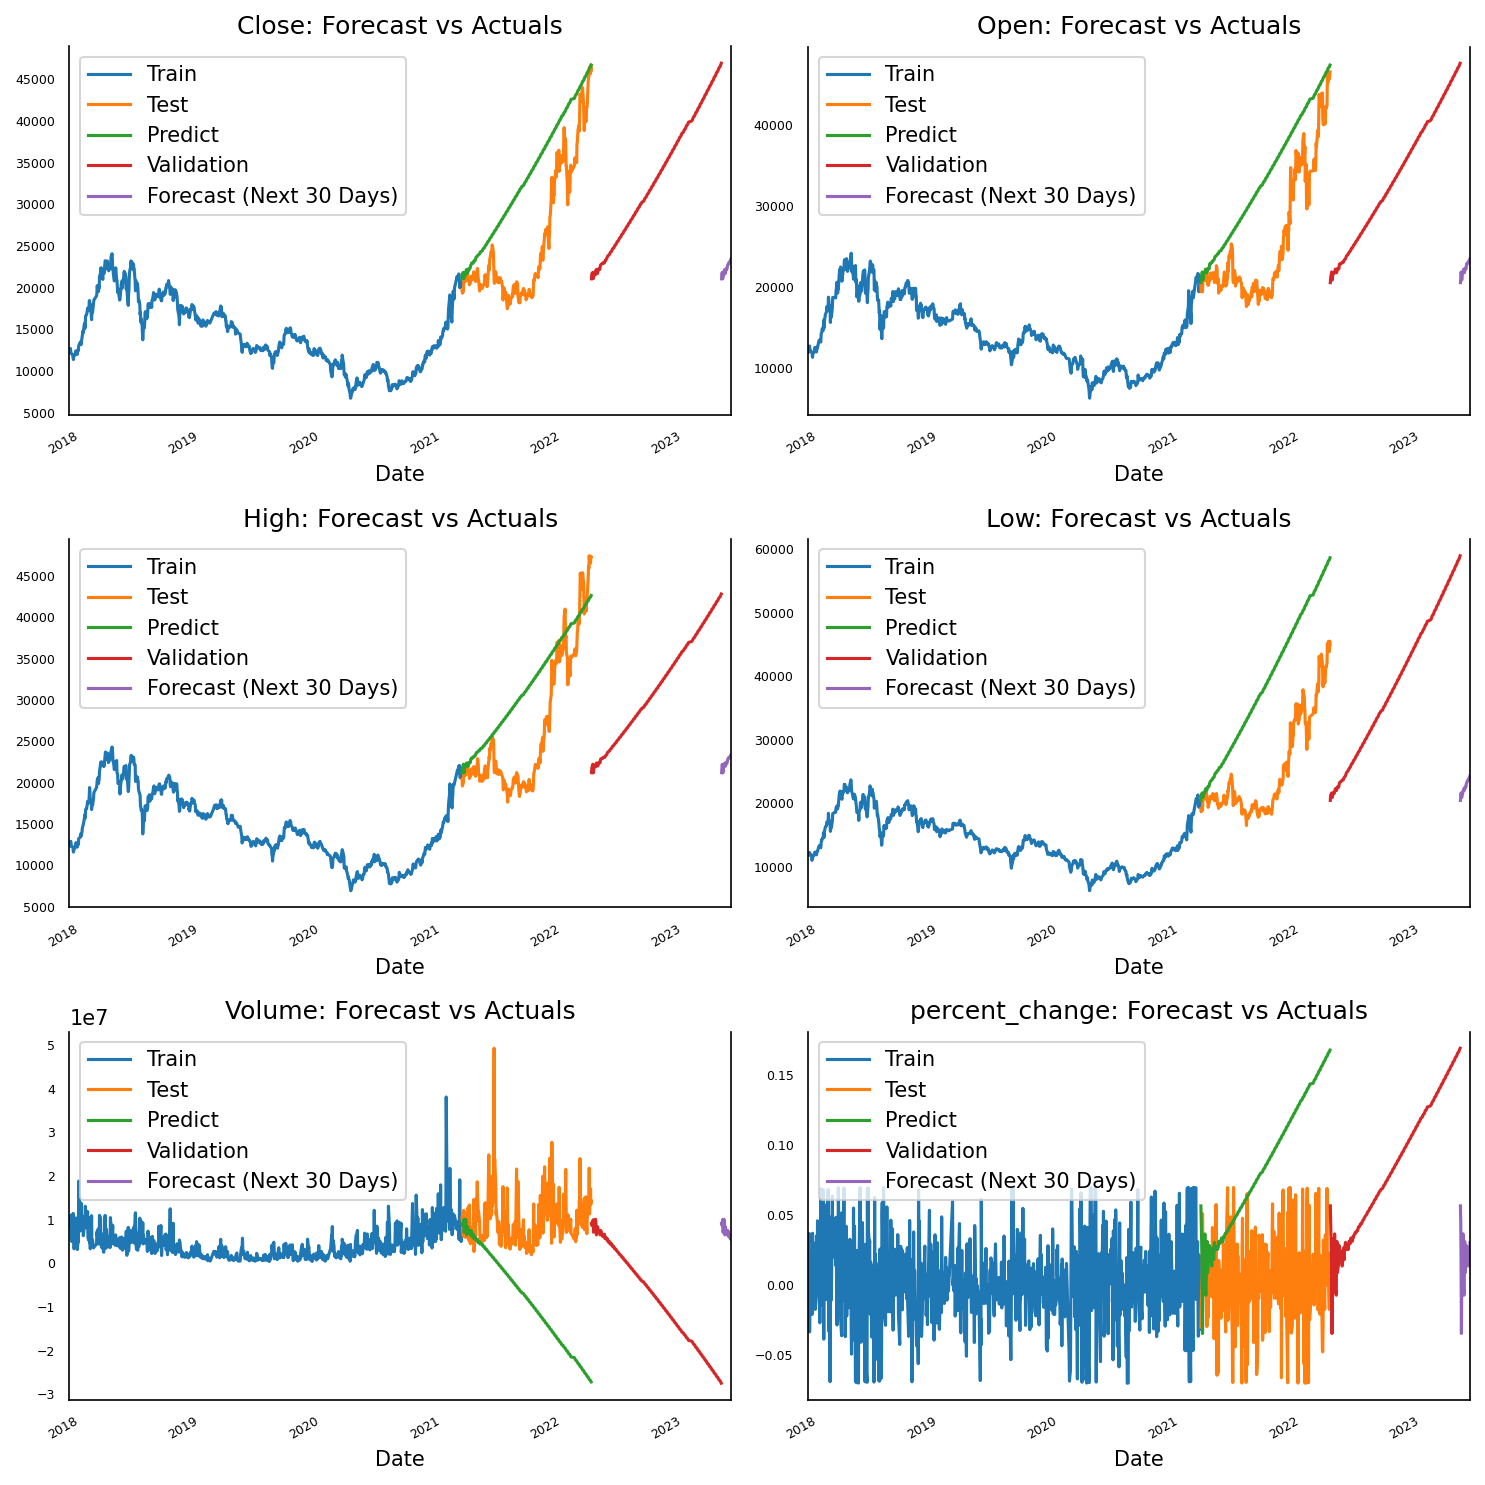

In [60]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    df_train[col].plot(legend=True, ax=ax, label='Train')
    df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')
    
    df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)
    df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)
    df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')
    
    
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()
